Assignment 2

Importing dataset

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.datasets import mnist

# 1. Load the MNIST dataset
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = mnist.load_data()

# 2. Filter such that you are dealing with only 1000 images of each number
def filter_mnist(x, y, limit=1000):
    x_filtered, y_filtered = [], []
    for digit in range(10):
        # Get indices for this specific digit
        indices = np.where(y == digit)[0][:limit]
        x_filtered.append(x[indices])
        y_filtered.append(y[indices])

    # Concatenate and shuffle to randomize training
    x_arr = np.concatenate(x_filtered, axis=0)
    y_arr = np.concatenate(y_filtered, axis=0)
    perm = np.random.permutation(x_arr.shape[0])

    # Flatten (784 features) and Normalize to range [0, 1]
    X = x_arr[perm].reshape(x_arr.shape[0], -1).T / 255.0
    # Convert labels to One-Hot Encoding (10 classes)
    Y = np.eye(10)[y_arr[perm]].T
    return X, Y

X_train, Y_train = filter_mnist(x_train_orig, y_train_orig, 1000)
X_test, Y_test = filter_mnist(x_test_orig, y_test_orig, 200)

Activation function

In [14]:
def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

def softmax(z):
    # Numerical stability: subtract max(z)
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

def derivative_tanh(x):
    # derivative of tanh is 1 - tanh^2(x)
    return 1 - np.power(np.tanh(x), 2)

def derivative_relu(x):
    return (x > 0).astype(float)

Initiallizing parameters

In [15]:
def initialize_parameters(n_x, n_h, n_y):
    # Initialize W randomly and B with zeros
    w1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    w2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    parameters = {"w1": w1, "b1": b1, "w2": w2, "b2": b2}
    return parameters

Forward and backward Propogation

In [16]:
def forward_prop(x, parameters):
    w1, b1, w2, b2 = parameters['w1'], parameters['b1'], parameters['w2'], parameters['b2']
    # Layer 1: f(W1*X + B1)
    z1 = np.dot(w1, x) + b1
    a1 = tanh(z1)
    # Layer 2: Softmax(W2*A1 + B2)
    z2 = np.dot(w2, a1) + b2
    a2 = softmax(z2)
    return {"z1": z1, "a1": a1, "z2": z2, "a2": a2}

def backward_prop(x, y, parameters, forward_cache):
    m = x.shape[1]
    w2 = parameters['w2']
    a1, a2, z1 = forward_cache['a1'], forward_cache['a2'], forward_cache['z1']
    # Gradients calculated based on equations
    dz2 = a2 - y
    dw2 = (1/m) * np.dot(dz2, a1.T)
    db2 = (1/m) * np.sum(dz2, axis=1, keepdims=True)
    dz1 = np.dot(w2.T, dz2) * derivative_tanh(z1)
    dw1 = (1/m) * np.dot(dz1, x.T)
    db1 = (1/m) * np.sum(dz1, axis=1, keepdims=True)
    return {"dw1": dw1, "db1": db1, "dw2": dw2, "db2": db2}

Updating the parameters and the cost function

In [17]:
def cost_function(a2, y):
    m = y.shape[1]
    # Cross-entropy cost formula
    cost = -(1/m) * np.sum(np.sum(y * np.log(a2 + 1e-8), axis=0, keepdims=True))
    return np.squeeze(cost)

def update_parameters(parameters, gradients, learning_rate):
    # Parameter update rule
    w1 = parameters['w1'] - learning_rate * gradients['dw1']
    b1 = parameters['b1'] - learning_rate * gradients['db1']
    w2 = parameters['w2'] - learning_rate * gradients['dw2']
    b2 = parameters['b2'] - learning_rate * gradients['db2']
    return {"w1": w1, "b1": b1, "w2": w2, "b2": b2}

MODEL

cost after 0 iters is 2.3032304438381037
cost after 50 iters is 2.1998222112097707
cost after 100 iters is 1.758990972077072
cost after 150 iters is 1.229055299019632
cost after 200 iters is 0.9190331227803163
cost after 250 iters is 0.7385973838379799
cost after 300 iters is 0.6268358395477209
cost after 350 iters is 0.5525460278589328
cost after 400 iters is 0.5000310453941649
cost after 450 iters is 0.46113336360349416


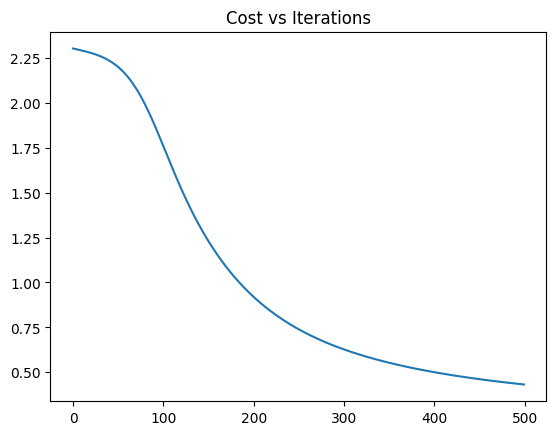

Accuracy: 85.5%


In [18]:
def model(x, y, n_h, learning_rate, iterations):
    n_x, n_y = x.shape[0], y.shape[0]
    cost_list = []
    parameters = initialize_parameters(n_x, n_h, n_y)

    for i in range(iterations):
        cache = forward_prop(x, parameters)
        cost = cost_function(cache['a2'], y)
        grads = backward_prop(x, y, parameters, cache)
        parameters = update_parameters(parameters, grads, learning_rate)
        cost_list.append(cost)
        if i % (iterations // 10) == 0:
            print(f"cost after {i} iters is {cost}")
    return parameters, cost_list

# Training
n_h, learning_rate, iterations = 100, 0.05, 500
Parameters, Cost_list = model(X_train, Y_train, n_h, learning_rate, iterations)

# Visualization (Fixed t-range)
plt.plot(np.arange(0, iterations), Cost_list)
plt.title("Cost vs Iterations")
plt.show()

# Accuracy Check
def accuracy(inp, labels, parameters):
    a_out = forward_prop(inp, parameters)['a2']
    return np.mean(np.argmax(a_out, 0) == np.argmax(labels, 0)) * 100

print(f"Accuracy: {accuracy(X_test, Y_test, Parameters)}%")